# KNN - UNSW

In [1]:
cd C:\\Users\\Sharuka Thirimanne\\Desktop\\FYP-ML-IDS

C:\Users\Sharuka Thirimanne\Desktop\FYP-ML-IDS


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


In [3]:
def load_train_dataset():
    df_train = pd.read_csv('USNW_train-set.csv')
    
    limit1 = df_train.shape[1]-1
    
    X_train = df_train.iloc[:,0:limit1]
    Y_train = df_train.iloc[:,limit1]
    
    return  X_train, Y_train,  df_train

X_train, Y_train,  df_train = load_train_dataset()

In [4]:
def load_test_dataset():
    df_test = pd.read_csv('USNW_test-set.csv')

    limit2 = df_test.shape[1]-1
    
    X_test = df_test.iloc[:,0:limit2]
    Y_test = df_test.iloc[:,limit2]
    
    return X_test, Y_test,df_test

X_test, Y_test ,df_test = load_test_dataset()

Performed one hot encoding on training set and test set separetely to avoid data leakage. 

In [8]:
X_train, X_val , Y_train , Y_val = train_test_split(X_train,Y_train, test_size=0.065,stratify = Y_train,shuffle=True,random_state=42)

print('Training X   :',X_train.shape)
print('Validation X :',X_val.shape)
print('Test_X       :',X_test.shape)
print('Training_Y   :',Y_train.shape)
print('Validation Y :',Y_val.shape)
print('Test_Y       :',Y_test.shape)

Training X   : (87781, 39)
Validation X : (6103, 39)
Test_X       : (52347, 39)
Training_Y   : (87781,)
Validation Y : (6103,)
Test_Y       : (52347,)


In [12]:
knn_classifier = KNeighborsClassifier(n_neighbors = 15, p = 1,weights='distance', algorithm = 'ball_tree').fit(X_train,Y_train)

In [13]:
test_predictions = knn_classifier.predict(X_test)

print("Cross-Validation set accuracy: {:.6f} %".format((cross_val_score(knn_classifier, X_val, Y_val, 
                                                                        cv=2,scoring='accuracy').mean())*100))
print("Train set accuracy           : {:.6f} %".format(knn_classifier.score(X_train,Y_train)*100))
print("Test set accuracy            : {:.6f} %".format(accuracy_score(Y_test, test_predictions)*100))

Cross-Validation set accuracy: 90.938966 %
Train set accuracy           : 100.000000 %
Test set accuracy            : 81.530938 %


In [19]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.text(0.3,2.6,'True Negatives  : '+ str(cm[0][0]),size=14)
    plt.text(0.3,2.8,'False Positives   : '+ str(cm[0][1]),size=14)
    plt.text(0.3,3,'False Negatives : '+ str(cm[1][0]),size=14)
    plt.text(0.3,3.2,'True Positives    : '+ str(cm[1][1]),size=14)

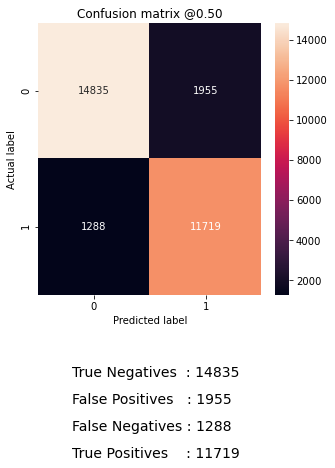

In [20]:
plot_cm(Y_test, test_predictions)

In [21]:
print(classification_report(Y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     16790
           1       0.86      0.90      0.88     13007

    accuracy                           0.89     29797
   macro avg       0.89      0.89      0.89     29797
weighted avg       0.89      0.89      0.89     29797



c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


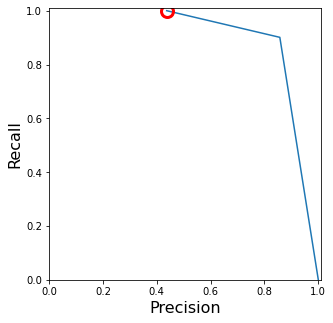

In [22]:
from sklearn.metrics import precision_recall_curve

#y_scores_lr = knn_classifier.fit(X_train, Y_train).decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(Y_test, test_predictions)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure(figsize=(10,5))
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

In [23]:
from sklearn.metrics import roc_curve, auc

c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


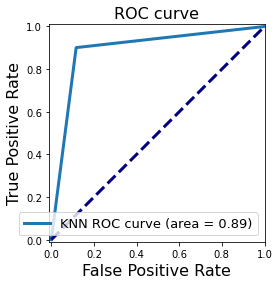

In [24]:
fpr_lr, tpr_lr, _ = roc_curve(Y_test, test_predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='KNN ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [11]:
n_neighbors = list(range(1,200,2))
p=[1,2]

param_grid = [
    {'n_neighbors' : n_neighbors,
     'p':p,
     'weights':['uniform','distance'],
     'algorithm':['ball_tree','kd_tree','brute']
    },]

optimal_params = GridSearchCV(
    estimator = knn_classifier,
    param_grid = param_grid,
    cv=2,
    scoring ='accuracy',
    verbose = 2)

optimal_params.fit(X_val,Y_val)
print(optimal_params.best_params_)

Fitting 2 folds for each of 1200 candidates, totalling 2400 fits
[CV] algorithm=ball_tree, n_neighbors=1, p=1, weights=uniform ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  algorithm=ball_tree, n_neighbors=1, p=1, weights=uniform, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=1, p=1, weights=uniform ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  algorithm=ball_tree, n_neighbors=1, p=1, weights=uniform, total=   0.4s
[CV] algorithm=ball_tree, n_neighbors=1, p=1, weights=distance .......
[CV]  algorithm=ball_tree, n_neighbors=1, p=1, weights=distance, total=   0.4s
[CV] algorithm=ball_tree, n_neighbors=1, p=1, weights=distance .......
[CV]  algorithm=ball_tree, n_neighbors=1, p=1, weights=distance, total=   0.4s
[CV] algorithm=ball_tree, n_neighbors=1, p=2, weights=uniform ........
[CV]  algorithm=ball_tree, n_neighbors=1, p=2, weights=uniform, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=1, p=2, weights=uniform ........
[CV]  algorithm=ball_tree, n_neighbors=1, p=2, weights=uniform, total=   0.4s
[CV] algorithm=ball_tree, n_neighbors=1, p=2, weights=distance .......
[CV]  algorithm=ball_tree, n_neighbors=1, p=2, weights=distance, total=   0.4s
[CV] algorithm=ball_tree, n_neighbors=1, p=2, weights=distance .......
[CV]  algorithm=ball_tree, n_neighbors=1, p=2, weights=distance, total=   0.3s
[CV] algorithm=ball_tree

[CV]  algorithm=ball_tree, n_neighbors=15, p=1, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=15, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=15, p=1, weights=uniform, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=15, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=15, p=1, weights=distance, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=15, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=15, p=1, weights=distance, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=15, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=15, p=2, weights=uniform, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=15, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=15, p=2, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=15, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=15, p=2, weights=distance, total=   0.6s
[CV] algorithm=bal

[CV]  algorithm=ball_tree, n_neighbors=27, p=2, weights=distance, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=29, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=29, p=1, weights=uniform, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=29, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=29, p=1, weights=uniform, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=29, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=29, p=1, weights=distance, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=29, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=29, p=1, weights=distance, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=29, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=29, p=2, weights=uniform, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=29, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=29, p=2, weights=uniform, total=   0.6s
[CV] algorithm=bal

[CV]  algorithm=ball_tree, n_neighbors=41, p=2, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=41, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=41, p=2, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=43, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=43, p=1, weights=uniform, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=43, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=43, p=1, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=43, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=43, p=1, weights=distance, total=   0.5s
[CV] algorithm=ball_tree, n_neighbors=43, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=43, p=1, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=43, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=43, p=2, weights=uniform, total=   0.7s
[CV] algorithm=ba

[CV]  algorithm=ball_tree, n_neighbors=55, p=2, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=55, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=55, p=2, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=55, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=55, p=2, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=57, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=57, p=1, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=57, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=57, p=1, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=57, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=57, p=1, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=57, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=57, p=1, weights=distance, total=   0.6s
[CV] algorithm=ba

[CV]  algorithm=ball_tree, n_neighbors=69, p=2, weights=uniform, total=   1.3s
[CV] algorithm=ball_tree, n_neighbors=69, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=69, p=2, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=69, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=69, p=2, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=69, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=69, p=2, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=71, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=71, p=1, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=71, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=71, p=1, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=71, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=71, p=1, weights=distance, total=   0.6s
[CV] algorithm=bal

[CV]  algorithm=ball_tree, n_neighbors=83, p=1, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=83, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=83, p=2, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=83, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=83, p=2, weights=uniform, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=83, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=83, p=2, weights=distance, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=83, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=83, p=2, weights=distance, total=   0.6s
[CV] algorithm=ball_tree, n_neighbors=85, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=85, p=1, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=85, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=85, p=1, weights=uniform, total=   0.7s
[CV] algorithm=bal

[CV]  algorithm=ball_tree, n_neighbors=97, p=1, weights=distance, total=   1.3s
[CV] algorithm=ball_tree, n_neighbors=97, p=1, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=97, p=1, weights=distance, total=   1.3s
[CV] algorithm=ball_tree, n_neighbors=97, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=97, p=2, weights=uniform, total=   1.4s
[CV] algorithm=ball_tree, n_neighbors=97, p=2, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=97, p=2, weights=uniform, total=   1.4s
[CV] algorithm=ball_tree, n_neighbors=97, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=97, p=2, weights=distance, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=97, p=2, weights=distance ......
[CV]  algorithm=ball_tree, n_neighbors=97, p=2, weights=distance, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=99, p=1, weights=uniform .......
[CV]  algorithm=ball_tree, n_neighbors=99, p=1, weights=uniform, total=   0.7s
[CV] algorithm=ba

[CV]  algorithm=ball_tree, n_neighbors=111, p=1, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=111, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=111, p=1, weights=distance, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=111, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=111, p=1, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=111, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=111, p=2, weights=uniform, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=111, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=111, p=2, weights=uniform, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=111, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=111, p=2, weights=distance, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=111, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=111, p=2, weights=distance, total=   0.7s
[CV] algor

[CV]  algorithm=ball_tree, n_neighbors=125, p=1, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=125, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=125, p=1, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=125, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=125, p=1, weights=distance, total=   0.7s
[CV] algorithm=ball_tree, n_neighbors=125, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=125, p=1, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=125, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=125, p=2, weights=uniform, total=   1.6s
[CV] algorithm=ball_tree, n_neighbors=125, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=125, p=2, weights=uniform, total=   1.7s
[CV] algorithm=ball_tree, n_neighbors=125, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=125, p=2, weights=distance, total=   1.5s
[CV] algori

[CV]  algorithm=ball_tree, n_neighbors=137, p=2, weights=distance, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=139, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=139, p=1, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=139, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=139, p=1, weights=uniform, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=139, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=139, p=1, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=139, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=139, p=1, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=139, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=139, p=2, weights=uniform, total=   1.0s
[CV] algorithm=ball_tree, n_neighbors=139, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=139, p=2, weights=uniform, total=   1.0s
[CV] algori

[CV]  algorithm=ball_tree, n_neighbors=151, p=2, weights=distance, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=151, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=151, p=2, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=153, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=153, p=1, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=153, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=153, p=1, weights=uniform, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=153, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=153, p=1, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=153, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=153, p=1, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=153, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=153, p=2, weights=uniform, total=   1.5s
[CV] algor

[CV]  algorithm=ball_tree, n_neighbors=165, p=2, weights=uniform, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=165, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=165, p=2, weights=distance, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=165, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=165, p=2, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=167, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=167, p=1, weights=uniform, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=167, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=167, p=1, weights=uniform, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=167, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=167, p=1, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=167, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=167, p=1, weights=distance, total=   0.8s
[CV] algor

[CV]  algorithm=ball_tree, n_neighbors=179, p=2, weights=uniform, total=   1.0s
[CV] algorithm=ball_tree, n_neighbors=179, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=179, p=2, weights=uniform, total=   1.0s
[CV] algorithm=ball_tree, n_neighbors=179, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=179, p=2, weights=distance, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=179, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=179, p=2, weights=distance, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=181, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=181, p=1, weights=uniform, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=181, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=181, p=1, weights=uniform, total=   1.0s
[CV] algorithm=ball_tree, n_neighbors=181, p=1, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=181, p=1, weights=distance, total=   0.8s
[CV] algori

[CV]  algorithm=ball_tree, n_neighbors=193, p=1, weights=distance, total=   1.1s
[CV] algorithm=ball_tree, n_neighbors=193, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=193, p=2, weights=uniform, total=   1.2s
[CV] algorithm=ball_tree, n_neighbors=193, p=2, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=193, p=2, weights=uniform, total=   1.1s
[CV] algorithm=ball_tree, n_neighbors=193, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=193, p=2, weights=distance, total=   0.9s
[CV] algorithm=ball_tree, n_neighbors=193, p=2, weights=distance .....
[CV]  algorithm=ball_tree, n_neighbors=193, p=2, weights=distance, total=   1.0s
[CV] algorithm=ball_tree, n_neighbors=195, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=195, p=1, weights=uniform, total=   0.8s
[CV] algorithm=ball_tree, n_neighbors=195, p=1, weights=uniform ......
[CV]  algorithm=ball_tree, n_neighbors=195, p=1, weights=uniform, total=   0.9s
[CV] algori

[CV]  algorithm=kd_tree, n_neighbors=7, p=1, weights=distance, total=   0.4s
[CV] algorithm=kd_tree, n_neighbors=7, p=1, weights=distance .........
[CV]  algorithm=kd_tree, n_neighbors=7, p=1, weights=distance, total=   0.4s
[CV] algorithm=kd_tree, n_neighbors=7, p=2, weights=uniform ..........
[CV]  algorithm=kd_tree, n_neighbors=7, p=2, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=7, p=2, weights=uniform ..........
[CV]  algorithm=kd_tree, n_neighbors=7, p=2, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=7, p=2, weights=distance .........
[CV]  algorithm=kd_tree, n_neighbors=7, p=2, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=7, p=2, weights=distance .........
[CV]  algorithm=kd_tree, n_neighbors=7, p=2, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=9, p=1, weights=uniform ..........
[CV]  algorithm=kd_tree, n_neighbors=9, p=1, weights=uniform, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=9,

[CV]  algorithm=kd_tree, n_neighbors=21, p=1, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=21, p=1, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=21, p=1, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=21, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=21, p=2, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=21, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=21, p=2, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=21, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=21, p=2, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=21, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=21, p=2, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=23, p=1, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=23, p=1, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neigh

[CV]  algorithm=kd_tree, n_neighbors=35, p=1, weights=distance, total=   0.4s
[CV] algorithm=kd_tree, n_neighbors=35, p=1, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=35, p=1, weights=distance, total=   0.4s
[CV] algorithm=kd_tree, n_neighbors=35, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=35, p=2, weights=uniform, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=35, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=35, p=2, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=35, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=35, p=2, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=35, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=35, p=2, weights=distance, total=   1.0s
[CV] algorithm=kd_tree, n_neighbors=37, p=1, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=37, p=1, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neigh

[CV]  algorithm=kd_tree, n_neighbors=49, p=1, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=49, p=1, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=49, p=1, weights=distance, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=49, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=49, p=2, weights=uniform, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=49, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=49, p=2, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=49, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=49, p=2, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=49, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=49, p=2, weights=distance, total=   0.5s
[CV] algorithm=kd_tree, n_neighbors=51, p=1, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=51, p=1, weights=uniform, total=   0.5s
[CV] algorithm=kd_tree, n_neigh

[CV]  algorithm=kd_tree, n_neighbors=63, p=1, weights=distance, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=63, p=1, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=63, p=1, weights=distance, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=63, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=63, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=63, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=63, p=2, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, n_neighbors=63, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=63, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=63, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=63, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=65, p=1, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=65, p=1, weights=uniform, total=   0.6s
[CV] algorithm=kd_tree, n_neigh

[CV]  algorithm=kd_tree, n_neighbors=77, p=1, weights=distance, total=   1.3s
[CV] algorithm=kd_tree, n_neighbors=77, p=1, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=77, p=1, weights=distance, total=   1.1s
[CV] algorithm=kd_tree, n_neighbors=77, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=77, p=2, weights=uniform, total=   1.2s
[CV] algorithm=kd_tree, n_neighbors=77, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=77, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=77, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=77, p=2, weights=distance, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=77, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=77, p=2, weights=distance, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=79, p=1, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=79, p=1, weights=uniform, total=   0.7s
[CV] algorithm=kd_tree, n_neigh

[CV]  algorithm=kd_tree, n_neighbors=91, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=91, p=1, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=91, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=91, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=91, p=2, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, n_neighbors=91, p=2, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=91, p=2, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, n_neighbors=91, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=91, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=91, p=2, weights=distance ........
[CV]  algorithm=kd_tree, n_neighbors=91, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=93, p=1, weights=uniform .........
[CV]  algorithm=kd_tree, n_neighbors=93, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neigh

[CV]  algorithm=kd_tree, n_neighbors=105, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=105, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=105, p=1, weights=distance, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=105, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=105, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=105, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=105, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=105, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=105, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=105, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=105, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=107, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=107, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, 

[CV]  algorithm=kd_tree, n_neighbors=119, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=119, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=119, p=1, weights=distance, total=   0.6s
[CV] algorithm=kd_tree, n_neighbors=119, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=119, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=119, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=119, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=119, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=119, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=119, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=119, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=119, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=119, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, 

[CV]  algorithm=kd_tree, n_neighbors=133, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=133, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=133, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=133, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=133, p=1, weights=distance, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=133, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=133, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=133, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=133, p=2, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, n_neighbors=133, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=133, p=2, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, n_neighbors=133, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=133, p=2, weights=distance, total=   0.8s
[CV] algorithm=kd_tree, n

[CV]  algorithm=kd_tree, n_neighbors=145, p=2, weights=distance, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=147, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=147, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=147, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=147, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=147, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=147, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=147, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=147, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=147, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=147, p=2, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, n_neighbors=147, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=147, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n

[CV]  algorithm=kd_tree, n_neighbors=159, p=2, weights=distance, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=159, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=159, p=2, weights=distance, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=161, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=161, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=161, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=161, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=161, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=161, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=161, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=161, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=161, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=161, p=2, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, 

[CV]  algorithm=kd_tree, n_neighbors=173, p=2, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, n_neighbors=173, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=173, p=2, weights=distance, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=173, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=173, p=2, weights=distance, total=   1.4s
[CV] algorithm=kd_tree, n_neighbors=175, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=175, p=1, weights=uniform, total=   1.1s
[CV] algorithm=kd_tree, n_neighbors=175, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=175, p=1, weights=uniform, total=   0.9s
[CV] algorithm=kd_tree, n_neighbors=175, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=175, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=175, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=175, p=1, weights=distance, total=   0.9s
[CV] algorithm=kd_tree, 

[CV]  algorithm=kd_tree, n_neighbors=187, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=187, p=2, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=187, p=2, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=187, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=187, p=2, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n_neighbors=187, p=2, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=187, p=2, weights=distance, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=189, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=189, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=189, p=1, weights=uniform ........
[CV]  algorithm=kd_tree, n_neighbors=189, p=1, weights=uniform, total=   0.8s
[CV] algorithm=kd_tree, n_neighbors=189, p=1, weights=distance .......
[CV]  algorithm=kd_tree, n_neighbors=189, p=1, weights=distance, total=   0.7s
[CV] algorithm=kd_tree, n

[CV]  algorithm=brute, n_neighbors=1, p=1, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=1, p=2, weights=uniform ............
[CV]  algorithm=brute, n_neighbors=1, p=2, weights=uniform, total=   0.3s
[CV] algorithm=brute, n_neighbors=1, p=2, weights=uniform ............
[CV]  algorithm=brute, n_neighbors=1, p=2, weights=uniform, total=   0.3s
[CV] algorithm=brute, n_neighbors=1, p=2, weights=distance ...........
[CV]  algorithm=brute, n_neighbors=1, p=2, weights=distance, total=   0.2s
[CV] algorithm=brute, n_neighbors=1, p=2, weights=distance ...........
[CV]  algorithm=brute, n_neighbors=1, p=2, weights=distance, total=   0.2s
[CV] algorithm=brute, n_neighbors=3, p=1, weights=uniform ............
[CV]  algorithm=brute, n_neighbors=3, p=1, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=3, p=1, weights=uniform ............
[CV]  algorithm=brute, n_neighbors=3, p=1, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=3, p=1, weights=dis

[CV]  algorithm=brute, n_neighbors=15, p=2, weights=uniform, total=   0.4s
[CV] algorithm=brute, n_neighbors=15, p=2, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=15, p=2, weights=uniform, total=   0.4s
[CV] algorithm=brute, n_neighbors=15, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=15, p=2, weights=distance, total=   0.3s
[CV] algorithm=brute, n_neighbors=15, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=15, p=2, weights=distance, total=   0.3s
[CV] algorithm=brute, n_neighbors=17, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=17, p=1, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=17, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=17, p=1, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=17, p=1, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=17, p=1, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=17, p=1, wei

[CV]  algorithm=brute, n_neighbors=29, p=2, weights=uniform, total=   0.4s
[CV] algorithm=brute, n_neighbors=29, p=2, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=29, p=2, weights=uniform, total=   0.4s
[CV] algorithm=brute, n_neighbors=29, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=29, p=2, weights=distance, total=   0.3s
[CV] algorithm=brute, n_neighbors=29, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=29, p=2, weights=distance, total=   0.3s
[CV] algorithm=brute, n_neighbors=31, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=31, p=1, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=31, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=31, p=1, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=31, p=1, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=31, p=1, weights=distance, total=   0.6s
[CV] algorithm=brute, n_neighbors=31, p=1, wei

[CV]  algorithm=brute, n_neighbors=43, p=2, weights=uniform, total=   0.4s
[CV] algorithm=brute, n_neighbors=43, p=2, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=43, p=2, weights=uniform, total=   0.5s
[CV] algorithm=brute, n_neighbors=43, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=43, p=2, weights=distance, total=   0.3s
[CV] algorithm=brute, n_neighbors=43, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=43, p=2, weights=distance, total=   0.3s
[CV] algorithm=brute, n_neighbors=45, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=45, p=1, weights=uniform, total=   0.8s
[CV] algorithm=brute, n_neighbors=45, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=45, p=1, weights=uniform, total=   0.7s
[CV] algorithm=brute, n_neighbors=45, p=1, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=45, p=1, weights=distance, total=   0.6s
[CV] algorithm=brute, n_neighbors=45, p=1, wei

[CV]  algorithm=brute, n_neighbors=57, p=2, weights=uniform, total=   0.5s
[CV] algorithm=brute, n_neighbors=57, p=2, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=57, p=2, weights=uniform, total=   0.4s
[CV] algorithm=brute, n_neighbors=57, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=57, p=2, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=57, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=57, p=2, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=59, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=59, p=1, weights=uniform, total=   0.7s
[CV] algorithm=brute, n_neighbors=59, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=59, p=1, weights=uniform, total=   0.7s
[CV] algorithm=brute, n_neighbors=59, p=1, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=59, p=1, weights=distance, total=   0.6s
[CV] algorithm=brute, n_neighbors=59, p=1, wei

[CV]  algorithm=brute, n_neighbors=71, p=2, weights=uniform, total=   0.4s
[CV] algorithm=brute, n_neighbors=71, p=2, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=71, p=2, weights=uniform, total=   0.4s
[CV] algorithm=brute, n_neighbors=71, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=71, p=2, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=71, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=71, p=2, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=73, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=73, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=73, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=73, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=73, p=1, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=73, p=1, weights=distance, total=   0.7s
[CV] algorithm=brute, n_neighbors=73, p=1, wei

[CV]  algorithm=brute, n_neighbors=85, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=85, p=2, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=85, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=85, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=85, p=2, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=85, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=85, p=2, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=87, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=87, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=87, p=1, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=87, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=87, p=1, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=87, p=1, weights=distance, total=   0.7s
[CV] algorithm=brute, n_neighbors=87, p=1, wei

[CV]  algorithm=brute, n_neighbors=99, p=2, weights=uniform, total=   0.5s
[CV] algorithm=brute, n_neighbors=99, p=2, weights=uniform ...........
[CV]  algorithm=brute, n_neighbors=99, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=99, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=99, p=2, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=99, p=2, weights=distance ..........
[CV]  algorithm=brute, n_neighbors=99, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=101, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=101, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=101, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=101, p=1, weights=uniform, total=   0.8s
[CV] algorithm=brute, n_neighbors=101, p=1, weights=distance .........
[CV]  algorithm=brute, n_neighbors=101, p=1, weights=distance, total=   0.7s
[CV] algorithm=brute, n_neighbors=101, p=1,

[CV]  algorithm=brute, n_neighbors=113, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=113, p=2, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=113, p=2, weights=uniform, total=   0.5s
[CV] algorithm=brute, n_neighbors=113, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=113, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=113, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=113, p=2, weights=distance, total=   0.4s
[CV] algorithm=brute, n_neighbors=115, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=115, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=115, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=115, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=115, p=1, weights=distance .........
[CV]  algorithm=brute, n_neighbors=115, p=1, weights=distance, total=   0.8s
[CV] algorithm=brute, n_neighbors=115, 

[CV]  algorithm=brute, n_neighbors=127, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=127, p=2, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=127, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=127, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=127, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=127, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=127, p=2, weights=distance, total=   0.6s
[CV] algorithm=brute, n_neighbors=129, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=129, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=129, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=129, p=1, weights=uniform, total=   0.8s
[CV] algorithm=brute, n_neighbors=129, p=1, weights=distance .........
[CV]  algorithm=brute, n_neighbors=129, p=1, weights=distance, total=   0.7s
[CV] algorithm=brute, n_neighbors=129, 

[CV]  algorithm=brute, n_neighbors=141, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=141, p=2, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=141, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=141, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=141, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=141, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=141, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=143, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=143, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=143, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=143, p=1, weights=uniform, total=   0.8s
[CV] algorithm=brute, n_neighbors=143, p=1, weights=distance .........
[CV]  algorithm=brute, n_neighbors=143, p=1, weights=distance, total=   0.7s
[CV] algorithm=brute, n_neighbors=143, 

[CV]  algorithm=brute, n_neighbors=155, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=155, p=2, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=155, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=155, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=155, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=155, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=155, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=157, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=157, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=157, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=157, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=157, p=1, weights=distance .........
[CV]  algorithm=brute, n_neighbors=157, p=1, weights=distance, total=   0.8s
[CV] algorithm=brute, n_neighbors=157, 

[CV]  algorithm=brute, n_neighbors=169, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=169, p=2, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=169, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=169, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=169, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=169, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=169, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=171, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=171, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=171, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=171, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=171, p=1, weights=distance .........
[CV]  algorithm=brute, n_neighbors=171, p=1, weights=distance, total=   0.8s
[CV] algorithm=brute, n_neighbors=171, 

[CV]  algorithm=brute, n_neighbors=183, p=2, weights=uniform, total=   0.7s
[CV] algorithm=brute, n_neighbors=183, p=2, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=183, p=2, weights=uniform, total=   0.6s
[CV] algorithm=brute, n_neighbors=183, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=183, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=183, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=183, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=185, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=185, p=1, weights=uniform, total=   1.0s
[CV] algorithm=brute, n_neighbors=185, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=185, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=185, p=1, weights=distance .........
[CV]  algorithm=brute, n_neighbors=185, p=1, weights=distance, total=   0.8s
[CV] algorithm=brute, n_neighbors=185, 

[CV]  algorithm=brute, n_neighbors=197, p=2, weights=uniform, total=   0.7s
[CV] algorithm=brute, n_neighbors=197, p=2, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=197, p=2, weights=uniform, total=   0.7s
[CV] algorithm=brute, n_neighbors=197, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=197, p=2, weights=distance, total=   0.6s
[CV] algorithm=brute, n_neighbors=197, p=2, weights=distance .........
[CV]  algorithm=brute, n_neighbors=197, p=2, weights=distance, total=   0.5s
[CV] algorithm=brute, n_neighbors=199, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=199, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=199, p=1, weights=uniform ..........
[CV]  algorithm=brute, n_neighbors=199, p=1, weights=uniform, total=   0.9s
[CV] algorithm=brute, n_neighbors=199, p=1, weights=distance .........
[CV]  algorithm=brute, n_neighbors=199, p=1, weights=distance, total=   0.9s
[CV] algorithm=brute, n_neighbors=199, 

[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed: 28.6min finished
